# Analysis of Description and Suggest Words

Notebook to analyze text description + suggested words come the closest to NYT headlines for that day (as calculated by running cosine similarity on the text embeddings of both groups). [You’ll manually inspect some posts to define the range of cosine similarity that makes sense the most.]

**Author: Audrey Yip**

**Table of Contents**
1. [Read in data](#1)
2. [Process description and suggested words](#2)
3. [Create .csvs and get headline and keyword data](#3)     
4. [Compare lengths of substrings to filter videos](#4)
5. [Get word embeddings and calculate cosine similarity](#5)


<a class="anchor" id="1"></a>
### 1. Read in user data 

In [1]:
import os
import pandas as pd

/var/folders/ny/5mz_1h8j5c31x__pd0t4xhxw0000gn/T/ipykernel_87049/3571106454.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cwd = os.getcwd()
metadata_dir = f'{cwd}/../pre-processing/metadata-csv'
metadata_files = [file for file in os.listdir(metadata_dir) if "Sec2Gr3_" in file]      # only get metadata files for our group

dataframes = []

for file in metadata_files:
    file_path = os.path.join(metadata_dir, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

print('Total number of videos', len(combined_df))

Total number of videos 24915


In [3]:
# Initial Data filtering
# only take unique videos
df = combined_df.drop_duplicates(subset=['video_id'])

num_unique = len(df)
print('Total number of unique videos', num_unique)

# drop all videos where video_description and suggested_words are NaN
df.dropna(subset=['video_description', 'suggested_words'], how='all', inplace=True)
num_no_sugg_descr = len(df)

print("Without description and suggested words:", num_no_sugg_descr)

# drop all videos not created in US
df = df[df['video_locationcreated'] == 'US']
without_US = len(df)

print("Not Created In US:", without_US)

df


Total number of unique videos 22606
Without description and suggested words: 21752
Not Created In US: 13633


/var/folders/ny/5mz_1h8j5c31x__pd0t4xhxw0000gn/T/ipykernel_87049/1466515545.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['video_description', 'suggested_words'], how='all', inplace=True)


,video_id,video_timestamp,video_duration,video_locationcreated,suggested_words,video_diggcount,video_sharecount,video_commentcount,video_playcount,video_description,video_is_ad,video_stickers,author_username,author_name,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified
0,7273221955937914155,2023-08-30T16:56:01,37.0,US,"angels in tibet, angels in tibet dance, angels...",356300.0,5606.0,986.0,2000000.0,Replying to @jade🐉not perfect yet & i made a ...,False,NaN,thebeaulexx,beaulexx,NaN,NaN,NaN,NaN,NaN,False
4,7285397643725983008,2023-10-02T12:23:48,37.0,US,"Dream Academy, angels in tibet, Adela Dream Ac...",142700.0,1373.0,551.0,1000000.0,s/o to dream academy for teaching me how to da...,False,NaN,adelajergova,ADÉLA,NaN,NaN,NaN,NaN,NaN,False
12,7309159185550183723,2023-12-05T12:11:01,95.0,US,NaN,19200.0,5782.0,119.0,256800.0,$25 flights for people with Amazon Student Pri...,False,NaN,carielizabethh,cari,NaN,NaN,NaN,NaN,NaN,False
13,7308541182819175722,2023-12-03T20:12:40,102.0,US,NaN,85600.0,1210.0,9652.0,3900000.0,Replying to @Emily 🌸 today we’re making some D...,False,NaN,nattiejopo,Nattie | new mom & lifestyle,NaN,NaN,NaN,NaN,NaN,True
14,7307649122918567211,2023-12-01T10:30:58,110.0,US,"nattie christmas tree, sad baby beige, Step 2 ...",305900.0,23000.0,34400.0,8500000.0,Let’s give my toddler’s Step 2 my first christ...,False,NaN,nattiejopo,Nattie | new mom & lifestyle,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24907,7286461444554624299,2023-10-05T09:12:29,79.0,US,"university of pittsburgh assignment, Universit...",175000.0,9745.0,3089.0,1300000.0,how is this allowed….. #pitt #foryou #universi...,False,NaN,liliorozco77,Lili,NaN,NaN,NaN,NaN,NaN,False
24911,7285527057394584863,2023-10-02T20:46:05,59.0,US,NaN,25600.0,1494.0,182.0,209800.0,"They might be new to me, but they’ve all been ...",False,NaN,tuindian,The Urban Indian,NaN,NaN,NaN,NaN,NaN,False
24912,7284024264334806315,2023-09-28T19:34:23,29.0,US,"Chipotle, Chipotle Burrito, chipotle is my lif...",287000.0,59200.0,2627.0,4000000.0,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,False,NaN,asianchowdown,asianchowdown,NaN,NaN,NaN,NaN,NaN,False
24913,7284462467290303787,2023-09-29T23:55:02,9.0,US,NaN,40900.0,5961.0,230.0,377200.0,i could make a way cuter video but hiding his ...,False,NaN,roshnirekha_,roshni rekha,NaN,NaN,NaN,NaN,NaN,False


In [4]:
# create new column with just the dates
df['video_date'] = df['video_timestamp'].str[:10]

# access relevant columns
df = df[['video_id', 'video_date', 'video_description', 'suggested_words']]
df.head()

,video_id,video_date,video_description,suggested_words
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels..."
4,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac..."
12,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN
13,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN
14,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ..."


<a class="anchor" id="2"></a>
### 2. Process Description and Suggested Words

In [5]:
import re
from nltk.corpus import stopwords

# load stop_words
stop_words = set(stopwords.words('english'))

# create list of hashtags to omit, we will not expect to find these in headlines
stop_hashtags = ['fyp', 'foryou']

def clean_description(description):
    """
    Helper function, takes video description and splits into words, removes punctuation, emojis and stop words.
    """
    if pd.isna(description):  
        return [] 
    
    # remove numbers from the text
    description = re.sub(r'\d+', '', description)

    # split the description into words
    words = description.split()
    
    # remove punctuation and emojis, make everything lowercase
    cleaned_words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
    
    # remove stop words and words containing stop hashtags
    cleaned_words = [word for word in cleaned_words if word not in stop_words and not any(stop_tag in word for stop_tag in stop_hashtags)]

    # remove empty strings
    cleaned_words = [word for word in cleaned_words if word]
    
    return cleaned_words

def clean_sugg_words(sugg_words):
    """
    Helper function, takes suggested words and splits into words, converts to lowercase and removes stop words.
    """
    if pd.isna(sugg_words):  
        return [] 
    
    # remove numbers from the text
    sugg_words = re.sub(r'\d+', '', sugg_words)
    
    # split the suggested words into individual words
    words = sugg_words.split(',')
    
    # split each word by white space
    words = [sub_word.strip().lower() for word in words for sub_word in word.split()]

    # convert each word to lowercase and remove  whitespace
    words = [word.strip().lower() for word in words]
    
    # remove stop words
    cleaned_words = [word for word in words if word not in stop_words]
    
    return cleaned_words

In [6]:
# apply helper functions to create new column in dataframe
df['video_keywords'] = df['suggested_words'].apply(clean_sugg_words) + df['video_description'].apply(clean_description)

# filter out videos without keywords
df = df[df['video_keywords'].apply(len) > 0]      

df

/var/folders/ny/5mz_1h8j5c31x__pd0t4xhxw0000gn/T/ipykernel_87049/2451469188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['video_keywords'] = df['suggested_words'].apply(clean_sugg_words) + df['video_description'].apply(clean_description)


,video_id,video_date,video_description,suggested_words,video_keywords
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels...","[angels, tibet, angels, tibet, dance, angels, ..."
4,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac...","[dream, academy, angels, tibet, adela, dream, ..."
12,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN,"[flights, people, amazon, student, prime, holi..."
13,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN,"[replying, emily, today, making, diy, ornament..."
14,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ...","[nattie, christmas, tree, sad, baby, beige, st..."
...,...,...,...,...,...
24907,7286461444554624299,2023-10-05,how is this allowed….. #pitt #foryou #universi...,"university of pittsburgh assignment, Universit...","[university, pittsburgh, assignment, universit..."
24911,7285527057394584863,2023-10-02,"They might be new to me, but they’ve all been ...",NaN,"[might, new, theyve, grinding, long, time, inc..."
24912,7284024264334806315,2023-09-28,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,"Chipotle, Chipotle Burrito, chipotle is my lif...","[chipotle, chipotle, burrito, chipotle, life, ..."
24913,7284462467290303787,2023-09-29,i could make a way cuter video but hiding his ...,NaN,"[could, make, way, cuter, video, hiding, face,..."


<a class="anchor" id="3"></a>
### 3. Create .csvs and get headline and keyword data    

In [7]:
from get_nyt_articles_revised import filter_by_date

In [8]:
# helper functions for cleaning df of nyt articles

def split_keywords(text):
    """Split text into individual keywords based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # split text into individual keywords based on whitespace and punctuation
    keywords = re.findall(r'\b\w+\b', text)

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words

def clean_headline(text):
    """Split headline into individual words based on whitespace and punctuation, remove stop words"""
    if pd.isna(text):  # check if text is NaN
        return []  
    
    # remove numbers from the text
    text = re.sub(r'\d+', '', text)

    # split text into individual keywords based on whitespace and punctuation
    keywords = text.split()

    # remove stop words
    cleaned_words = [word.lower() for word in keywords if word not in stop_words]
    
    return cleaned_words


In [9]:
df.reset_index(drop=True, inplace=True)
df

,video_id,video_date,video_description,suggested_words,video_keywords
0,7273221955937914155,2023-08-30,Replying to @jade🐉not perfect yet & i made a ...,"angels in tibet, angels in tibet dance, angels...","[angels, tibet, angels, tibet, dance, angels, ..."
1,7285397643725983008,2023-10-02,s/o to dream academy for teaching me how to da...,"Dream Academy, angels in tibet, Adela Dream Ac...","[dream, academy, angels, tibet, adela, dream, ..."
2,7309159185550183723,2023-12-05,$25 flights for people with Amazon Student Pri...,NaN,"[flights, people, amazon, student, prime, holi..."
3,7308541182819175722,2023-12-03,Replying to @Emily 🌸 today we’re making some D...,NaN,"[replying, emily, today, making, diy, ornament..."
4,7307649122918567211,2023-12-01,Let’s give my toddler’s Step 2 my first christ...,"nattie christmas tree, sad baby beige, Step 2 ...","[nattie, christmas, tree, sad, baby, beige, st..."
...,...,...,...,...,...
13546,7286461444554624299,2023-10-05,how is this allowed….. #pitt #foryou #universi...,"university of pittsburgh assignment, Universit...","[university, pittsburgh, assignment, universit..."
13547,7285527057394584863,2023-10-02,"They might be new to me, but they’ve all been ...",NaN,"[might, new, theyve, grinding, long, time, inc..."
13548,7284024264334806315,2023-09-28,CHIPOTLE IS MY LiFeeeeee #chipotle #food #burr...,"Chipotle, Chipotle Burrito, chipotle is my lif...","[chipotle, chipotle, burrito, chipotle, life, ..."
13549,7284462467290303787,2023-09-29,i could make a way cuter video but hiding his ...,NaN,"[could, make, way, cuter, video, hiding, face,..."


In [10]:
rows = []
total_num_videos = len(df)
uncollected = []

# iterate over each row in the video DataFrame
for index, row in df.iterrows():
    print(f'Processing video {index+1}/{total_num_videos}, video id: {row['video_id']}')
    # get relevant NYT articles using the video date
    nyt_df = filter_by_date(row['video_date'])

    # get relevant keywords and combine lists
    if not nyt_df.empty:
        keywords_list = nyt_df['keywords'].apply(split_keywords)
        headline_list = nyt_df['headline'].apply(clean_headline)
    else:
        uncollected.append(row)

    combined_list = [keyword + headline for keyword, headline in zip(keywords_list, headline_list)]
    flat_list = []
    [flat_list.extend(item) for item in combined_list]
    
    # Process the data and create a new row
    new_row = {
        'video_id': row['video_id'],
        'video_date': row['video_date'],
        'video_keywords': row['video_keywords'],
        'nyt_keywords': flat_list
    }
    
    # append the new row to the list of rows
    rows.append(new_row)

    if index+1 == total_num_videos:
        print("Reached last video ID. Exiting loop.")
        break

print("Done processing!")

# create DataFrame from the list of rows
comparison_df = pd.DataFrame(rows)

comparison_df

Processing video 1/13551, video id: 7273221955937914155
NYT data for 2023-08-30 already in folder

Processing video 2/13551, video id: 7285397643725983008
NYT data for 2023-10-02 already in folder



Processing video 3/13551, video id: 7309159185550183723
NYT data for 2023-12-05 already in folder

Processing video 4/13551, video id: 7308541182819175722
NYT data for 2023-12-03 already in folder

Processing video 5/13551, video id: 7307649122918567211
NYT data for 2023-12-01 already in folder

Processing video 6/13551, video id: 7308598201286937902
NYT data for 2023-12-03 already in folder

Processing video 7/13551, video id: 7303788835798863147
NYT data for 2023-11-21 already in folder

Processing video 8/13551, video id: 7308493561039736106
NYT data for 2023-12-03 already in folder

Processing video 9/13551, video id: 7307454332465728810
NYT data for 2023-11-30 already in folder

Processing video 10/13551, video id: 7302509037529140522
NYT data for 2023-11-17 already in folder

Processing video 11/13551, video id: 7309309846984133931
NYT data for 2023-12-05 already in folder

Processing video 12/13551, video id: 7309475042990083374
NYT data for 2023-12-06 already in folder

Process

,video_id,video_date,video_keywords,nyt_keywords
0,7273221955937914155,2023-08-30,"[angels, tibet, angels, tibet, dance, angels, ...","[floyd, willie, lewis, iii, trump, donald, j, ..."
1,7285397643725983008,2023-10-02,"[dream, academy, angels, tibet, adela, dream, ...","[national, parks, monuments, seashores, bears,..."
2,7309159185550183723,2023-12-05,"[flights, people, amazon, student, prime, holi...","[theater, theater, off, broadway, art, museums..."
3,7308541182819175722,2023-12-03,"[replying, emily, today, making, diy, ornament...","[paris, france, murders, attempted, murders, h..."
4,7307649122918567211,2023-12-01,"[nattie, christmas, tree, sad, baby, beige, st...","[patient, protection, affordable, care, act, 2..."
...,...,...,...,...
13546,7286461444554624299,2023-10-05,"[university, pittsburgh, assignment, universit...","[diet, nutrition, conflicts, interest, drugs, ..."
13547,7285527057394584863,2023-10-02,"[might, new, theyve, grinding, long, time, inc...","[national, parks, monuments, seashores, bears,..."
13548,7284024264334806315,2023-09-28,"[chipotle, chipotle, burrito, chipotle, life, ...","[day, care, centers, child, care, 3, d, printe..."
13549,7284462467290303787,2023-09-29,"[could, make, way, cuter, video, hiding, face,...","[movies, saw, x, movie, greutert, kevin, bell,..."


<a class="anchor" id="4"></a>
### 4. Compare lengths of substrings to filter videos

In [11]:
# find range for collecting articles
df['video_timestamp'] = pd.to_datetime(df['video_timestamp'])

# get the minimum and maximum dates
min_date = df['video_timestamp'].min()
max_date = df['video_timestamp'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

KeyError: 'video_timestamp'

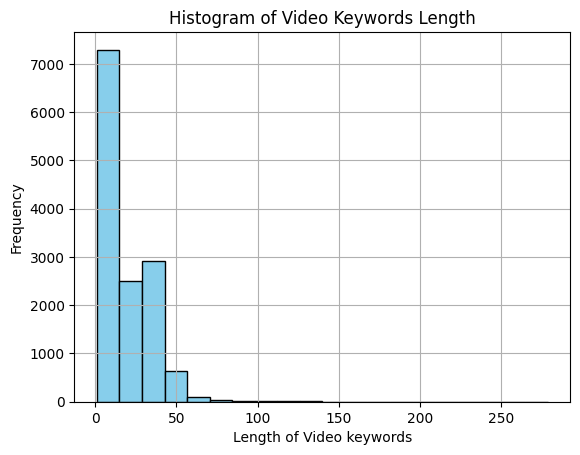

In [12]:
# create histogram to see nyt keyword lengths
import matplotlib.pyplot as plt

# calculate the length of each string in the 'video_keywords' column
keyword_lengths = comparison_df['video_keywords'].apply(len)

# create a histogram
plt.hist(keyword_lengths, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Length of Video keywords')
plt.ylabel('Frequency')
plt.title('Histogram of Video Keywords Length')
plt.grid(True)
plt.show()

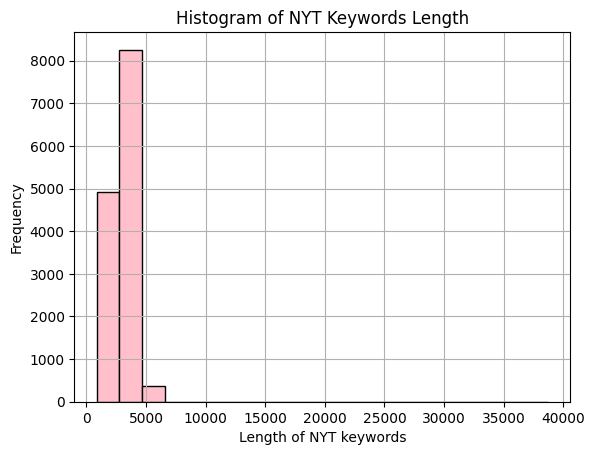

In [13]:
# create histogram to see video keyword lengths

# Calculate the length of each string in the 'video_keywords' column
keyword_lengths = comparison_df['nyt_keywords'].apply(len)

# Create a histogram
plt.hist(keyword_lengths, bins=20, color='pink', edgecolor='black')
plt.xlabel('Length of NYT keywords')
plt.ylabel('Frequency')
plt.title('Histogram of NYT Keywords Length')
plt.grid(True)
plt.show()

In [17]:
comparison_df_filtered = comparison_df[comparison_df['nyt_keywords'].apply(len) <= 1000].copy()

In [18]:
comparison_df_filtered

,video_id,video_date,video_keywords,nyt_keywords
5180,6846098741590494469,2020-07-05,"[burrs, walk, tho, im, gonna, tiktok, look, gu...","[masks, newspapers, cartoons, cartoonists, kel..."
8037,7180997405251308843,2022-12-25,"[highlighter, markers, highlighter, love, stor...","[edelman, alex, comedian, comedy, humor, chris..."


<a class="anchor" id="5"></a>
### 5. Get word embeddings and calculate cosine similarity

In [19]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

2024-03-14 00:58:44.234686: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# load the Universal Sentence Encoder's TF Hub module
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [22]:
# cosine similarity function, from week 7 notebook
from numpy.linalg import norm

def cosineSimilarity(vec1, vec2):
    """Calculate the cosine similarity between two vectors."""
    V1 = np.array(vec1)
    V2 = np.array(vec2)
    cosine = np.dot(V1, V2)/(norm(V1)*norm(V2))
    return cosine

In [24]:
# create sentences for analysis
comparison_df['video_sentences'] = comparison_df.apply(lambda row: " ".join(row['video_keywords']), axis=1)
comparison_df['nyt_sentences'] = comparison_df.apply(lambda row: " ".join(row['nyt_keywords']), axis=1)

In [25]:
# calculate cosine similarities and add them to the dictionary

cosine_similarities = {}

for index, row in comparison_df.iterrows():
    video_id = row['video_id']
    video_sentence = row['video_sentences']
    #print(type(video_sentence))
    nyt_sentence = row['nyt_sentences']
    
    # calculate embeddings for video sentence
    video_embedding = embed([video_sentence])[0]    # not sure why??
    nyt_embedding = embed([nyt_sentence])[0]
    
    # calculate cosine similarity
    cosine_sim = cosineSimilarity(video_embedding, nyt_embedding)

    # add to dictionary
    cosine_similarities[video_id] = cosine_sim

cosine_similarities

{7273221955937914155: 0.17501032,
 7285397643725983008: 0.22656588,
 7309159185550183723: 0.13385576,
 7308541182819175722: 0.20176858,
 7307649122918567211: 0.21346167,
 7308598201286937902: 0.09532142,
 7303788835798863147: 0.09782946,
 7308493561039736106: 0.062197305,
 7307454332465728810: -0.00022438352,
 7302509037529140522: 0.08734835,
 7309309846984133931: -0.015278981,
 7309475042990083374: 0.05558805,
 7307483427417214254: 0.041497324,
 7304525431334571310: 0.07764088,
 7304361579066445102: -0.0050181905,
 7309185926003985707: 0.16304298,
 7290020890689965358: 0.11177867,
 7309173608817954090: 0.07716452,
 7309522024194526510: 0.005635554,
 7309236598254701870: 0.072476864,
 7308570521841552682: 0.14427924,
 7304494103281028395: -0.013249271,
 7304493516271504686: 0.037467718,
 7308000216790093099: 0.12434544,
 7294817425965567278: 0.18163384,
 7308700504182328618: 0.048492208,
 7308594223853374763: 0.18564391,
 7305904123122060575: 0.086796924,
 7304757623600057631: 0.029610

Mean: 0.08634382
Median: 0.08647294
Standard Deviation: 0.06244244
Minimum Value: -0.15964217
Maximum Value: 0.6079339


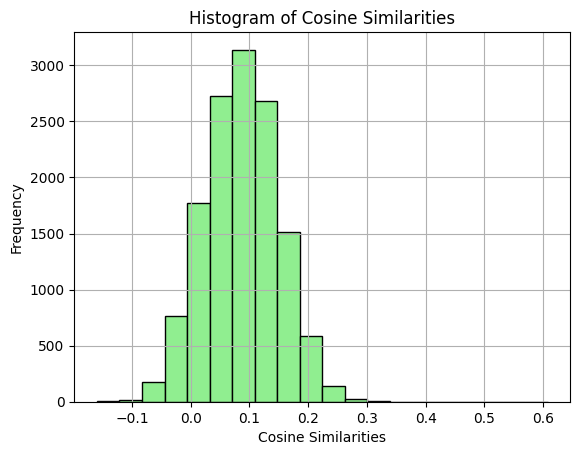

In [26]:
# inspect cosine similarities
import matplotlib.pyplot as plt

# extracting values from the dictionary
values = list(cosine_similarities.values())

# calculate summary statistics
mean = np.mean(values)
median = np.median(values)
std_dev = np.std(values)
min_val = np.min(values)
max_val = np.max(values)

print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

# create histogram
plt.hist(values, bins=20, color='lightgreen', edgecolor='black')
plt.title('Histogram of Cosine Similarities')
plt.xlabel('Cosine Similarities')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [28]:
sorted_cosine_similarity = sorted(cosine_similarities.items(), key=lambda x: x[1], reverse=True)
top_50_cosine_similarities = sorted_cosine_similarity[:50]
top_50_cosine_similarities

[(7289223591458131231, 0.6079339),
 (7276934429958819118, 0.41114193),
 (7164475041780862254, 0.3249353),
 (7290935475504680234, 0.3117478),
 (7301947792623406382, 0.30852073),
 (7295171179319446830, 0.30557448),
 (7287718882775797034, 0.3030686),
 (7280549804940299562, 0.30052096),
 (7299221179611499819, 0.29707345),
 (7292143951392492846, 0.2917627),
 (7223196407702850858, 0.28980744),
 (7204701530216254762, 0.28882775),
 (7187938405383146795, 0.2795448),
 (7064937870964067630, 0.27807805),
 (7283585182727195947, 0.2775189),
 (7239033699436678446, 0.2724427),
 (7294669041929653537, 0.27139145),
 (7180997405251308843, 0.27037543),
 (7295543009087671594, 0.26946458),
 (7288210342683872555, 0.26929542),
 (7268028851513560366, 0.26768872),
 (7288093462057045291, 0.26757655),
 (7288485809139764523, 0.26642597),
 (7274360866080902446, 0.26576057),
 (7291870089358363946, 0.26492777),
 (7194101754085100842, 0.26371643),
 (7298951188270042414, 0.2634431),
 (7282039404871306527, 0.2623574),
 (

In [32]:
# inspect dataframe
top_cosine_sim_rows = []

for video_id, cosine_similarity in top_50_cosine_similarities[:10]:
    # filter comparison_df for the current video_id
    row = comparison_df[comparison_df['video_id'] == video_id]
    top_cosine_sim_rows.append(row)

# concat rows
top_cosine_sim_df = pd.concat(top_cosine_sim_rows, ignore_index=True)
top_cosine_sim_df

,video_id,video_date,video_keywords,nyt_keywords,video_sentences,nyt_sentences
0,7289223591458131231,2023-10-12,"[nay, ohio, house, resolution, israel, easy, d...","[act, examination, tests, examinations, colleg...",nay ohio house resolution israel easy decision...,act examination tests examinations colleges un...
1,7276934429958819118,2023-09-09,"[i'm, regardless, pain, im, regardless, pain, ...","[justice, department, storming, us, capitol, j...",i'm regardless pain im regardless pain capcut ...,justice department storming us capitol jan 202...
2,7164475041780862254,2022-11-10,"[cma, awards, music, katy, perry, thomas, rhet...","[united, states, politics, government, interna...",cma awards music katy perry thomas rhett unfor...,united states politics government internal sub...
3,7290935475504680234,2023-10-17,"[edward, walpole, fell, ill, passed, away, you...","[ethics, official, misconduct, speeches, state...",edward walpole fell ill passed away younger br...,ethics official misconduct speeches statements...
4,7301947792623406382,2023-11-16,"[jaime, schaefer, codepink, medea, benjamin, z...","[trump, donald, j, presidential, election, 202...",jaime schaefer codepink medea benjamin zionist...,trump donald j presidential election 2024 spee...
5,7295171179319446830,2023-10-28,"[spent, hours, walking, around, blazing, sun, ...","[grand, central, terminal, manhattan, ny, demo...",spent hours walking around blazing sun cousins...,grand central terminal manhattan ny demonstrat...
6,7287718882775797034,2023-10-08,"[beautiful, places, beautiful, places, world, ...","[bonallack, michael, deaths, obituaries, golf,...",beautiful places beautiful places world beauti...,bonallack michael deaths obituaries golf briti...
7,7280549804940299562,2023-09-19,"[kennedy, walsh, kennedy, walsh, racism, gold,...","[football, college, coaches, managers, sexual,...",kennedy walsh kennedy walsh racism gold rush t...,football college coaches managers sexual haras...
8,7299221179611499819,2023-11-08,"[nepal, nepali, people, indian, vs, china, son...","[jews, judaism, terrorism, demonstrations, pro...",nepal nepali people indian vs china song chini...,jews judaism terrorism demonstrations protests...
9,7292143951392492846,2023-10-20,"[golden, gate, bridge, san, francisco's, golde...","[opera, berlin, state, opera, meier, waltraud,...",golden gate bridge san francisco's golden gate...,opera berlin state opera meier waltraud elektr...
